<a href="https://colab.research.google.com/github/ravishankar75/MLOPS_ASSN02_04/blob/main/GROUP44_MLOPS_M3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 44  - MLOPS M3
# Model selection and Hyperparameter tuning

SAKTHI R (2023AA05940)

ROBERTSEKAR R (2023AA05823)

RAVISHANKAR R (2023AA05171)

ARNAB GHOSH (2023AA05104)

In [ ]:
# ==================================================
# Install required packages
# ==================================================
!pip install h2o pyarrow polars seaborn matplotlib optuna xgboost joblib

In [ ]:
# ==================================================
# Import libraries
# ==================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.datasets import fashion_mnist

# ==================================================
# Load and Preprocess the FASHION MNIST dataset
# ==================================================

# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images from 28x28 to 784 feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize (standardize) data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to Pandas DataFrames
train_df = pd.DataFrame(X_train)
train_df['label'] = y_train

test_df = pd.DataFrame(X_test)
test_df['label'] = y_test

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Options for H2OAutoML
#### General Configuration


| Parameter          |Default       |Description                                                   |
|:--------------------|:--------------|:---------------------------------------------------------------|
| max_runtime_secs  | 3600 (1 hr)   | Time limit (in seconds) for the full AutoML run.              |
| max_models        | None          | Maximum number of models to train |
| nfolds           | 5             | Number of cross-validation folds. Set 0 to disable CV.       |
| seed             | None          | Random seed for reproducibility.                             |


#### Model Selection

| Parameter                      | Default | Description |
|--------------------------------|---------|-----------------------------------------------------------------|
| include_algos                  | None    | List of models to include (e.g., `['GLM', 'DRF', 'GBM', 'DeepLearning']`).|
| exclude_algos                  | None    | List of models to exclude (e.g., `['DeepLearning']`).                     |
| keep_cross_validation_models   | True    | Keep CV models after training (set to `False` to save memory).            |


🔹 **Available Algorithms in H2O AutoML:**
- **"GLM"** → Generalized Linear Models  
- **"DRF"** → Distributed Random Forest  
- **"GBM"** → Gradient Boosting Machines  
- **"DeepLearning"** → Neural Networks  
- **"XGBoost"** → Extreme Gradient Boosting  
- **"StackedEnsemble"** → Model ensembling

#### Stopping Conditions
| Parameter                          | Default  | Description                                                   |
|------------------------------------|----------|---------------------------------------------------------------|
| stopping_metric                    | "AUTO"   | Metric for early stopping (e.g., `"logloss", "AUC", "RMSE"`). |
| stopping_tolerance                 | 0.001    | Minimum improvement to continue training.                     |
| stopping_rounds                    | 3        | Stop training if no improvement for *n* rounds.              |
| keep_cross_validation_predictions  | True     | Keep predictions from cross-validation for ensembling.        |

### Other Options

| Parameter                     | Default  | Description                                                   |
|--------------------------------|----------|---------------------------------------------------------------|
| verbosity                      | "warn"   | Set to `"info"` or `"debug"` for more logs.                   |
| max_runtime_secs_per_model     | None     | Limit training time per model.                                |
| sort_metric                    | "AUTO"   | Sorting metric for leaderboard (e.g.,`"AUC", "logloss", "RMSE"`). |


In [ ]:
# ==================================================
# Start H2O cluster and prepare data for AutoML
# ==================================================

import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Convert DataFrames to H2OFrames
train_hf = h2o.H2OFrame(train_df)
test_hf = h2o.H2OFrame(test_df)

# Set features and target
y_col = 'label'
X_cols = train_hf.columns[:-1]


# ==================================================
# Run H2O AutoML for Model Selection
# ==================================================

aml = H2OAutoML(
    max_runtime_secs=3600,           # Total time budget for AutoML (10 min here)
    max_models=10,                   # Maximum number of models to train (increase for production)
    include_algos=['GLM', 'DRF', 'DeepLearning', 'XGBoost'],  # Algorithms to include
    seed=42,                        # Reproducibility
    verbosity="info"                # Verbose output
)

# Train AutoML on training data
aml.train(x=X_cols, y=y_col, training_frame=train_hf)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpppl5l7ps
  JVM stdout: /tmp/tmpppl5l7ps/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpppl5l7ps/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_6hq80o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.250 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:46:42.984: Project: AutoML_1_20250320_154642
15:46:42.986: Blending will be used.
15:46:42.987: Setting stopping tolerance adaptively based on the training frame: 0.00408248290463863
15:46:42.987: Build control seed: 42
15:46:42.993: Since cross-validation is disabled, and validation, blending frame(s) were not provided, automatically split the training data into training, validation, blending frame(s) in the ratio 70/10/20.
15:46:47.95: training frame: Frame key: AutoML_1_20250320_154642_training_Key_Frame__upload_b89c3c10927c4d6723b43f7ea355450d.hex    cols: 785    rows: 41874  chunks: 222    size: 185444500  checksum: -169128574543484045
15:46:47.546: validation frame: Frame key: AutoML_1_20250320_154642_validation_Key_Frame__upload_b89c3c10927c4d6723b43f7ea355450d.hex    co

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,1489413.0,20.0,20.0,20.0,2192.0,2477.0,2361.08
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2025-03-20 15:47:42,0.013 sec,0.0,nan,nan,nan,nan,nan,nan
,2025-03-20 15:49:41,1 min 59.354 sec,5.0,1.4221619,0.6645003,2.0225445,1.1812187,0.6068405,1.3952775
,2025-03-20 15:51:35,3 min 53.176 sec,10.0,1.2718684,0.6354763,1.6176491,1.1289790,0.5986228,1.2745935
,2025-03-20 15:53:29,5 min 46.603 sec,15.0,1.2010170,0.6235016,1.4424417,1.1071611,0.5903566,1.2258058
,2025-03-20 15:55:24,7 min 41.502 sec,20.0,1.1647070,0.6156352,1.3565424,1.0958863,0.5882129,1.2009668
,2025-03-20 15:57:16,9 min 33.860 sec,25.0,1.1462216,0.6117761,1.3138241,1.0921433,0.5867549,1.1927770
,2025-03-20 15:59:11,11 min 29.107 sec,30.0,1.1313065,0.6071119,1.2798543,1.0876526,0.5864411,1.1829883
,2025-03-20 16:01:04,13 min 22.115 sec,35.0,1.1231314,0.6054553,1.2614242,1.0864923,0.5862595,1.1804654


In [ ]:
# Evaluate the trained models
# Print the model leaderboard
print ("The model leaderboard :")
print ()
lb = aml.leaderboard
print (lb)

best_model = aml.leader
# Print the model details and performance of the best model
print ("The best performing model is:", best_model.model_id)
print ()
print (best_model.summary() )

print ()
print ("The performance measure of the best performing model is:")
print ()
perf = best_model.model_performance()
print(perf)

# Save as binary H2O model (for reloading in H2O)
h2o_save_path = h2o.save_model(model=best_model, path="./h2o_leader_model", force=True)
print(f"H2O Leader Model Saved at: {h2o_save_path}")

# Export as MOJO (portable, production-friendly format)
mojo_path = best_model.download_mojo(path="./h2o_leader_model_mojo", get_genmodel_jar=True)
print(f"H2O Leader MOJO Saved at: {mojo_path}")


The model leaderboard :

model_id                                                 rmse      mse       mae       rmsle    mean_residual_deviance
DRF_1_AutoML_1_20250320_154642                        1.08241  1.17161  0.58364     0.335752                   1.17161
XRT_1_AutoML_1_20250320_154642                        1.08408  1.17523  0.582921    0.337531                   1.17523
XGBoost_grid_1_AutoML_1_20250320_154642_model_2       1.13849  1.29616  0.648206  nan                          1.29616
XGBoost_grid_1_AutoML_1_20250320_154642_model_1       1.13941  1.29825  0.607626    0.34828                    1.29825
DeepLearning_1_AutoML_1_20250320_154642               1.15811  1.34122  0.677744  nan                          1.34122
XGBoost_3_AutoML_1_20250320_154642                    1.16874  1.36596  0.717993  nan                          1.36596
XGBoost_2_AutoML_1_20250320_154642                    1.17005  1.36903  0.675166  nan                          1.36903
XGBoost_1_AutoML_1_2025

In [ ]:
# ==================================================
# Export H2O Data to Pandas for Optuna Tuning
# ==================================================

# We'll fine-tune using Optuna, so we convert H2OFrame back to Pandas
train_pd = train_hf.as_data_frame(use_pandas=True, use_multi_thread=True)
test_pd = test_hf.as_data_frame(use_pandas=True, use_multi_thread=True)

# Split features and labels
X_train_np = train_pd.drop(columns=['label']).values
y_train_np = train_pd['label'].values

X_test_np = test_pd.drop(columns=['label']).values
y_test_np = test_pd['label'].values

# ==================================================
# Fine-Tune XGBoost (Best Model Type) with Optuna
# ==================================================

import optuna
import xgboost as xgb

# Split train into train and validation for Optuna tuning
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42
)

# Define Optuna objective function
def objective(trial):
    # Define hyperparameter search space
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',
        'num_class': 10,   # Fashion MNIST has 10 classes
        'eval_metric': 'mlogloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Train XGBoost model with current trial's parameters
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_split, y_train_split)

    # Predict on validation set
    preds = model.predict(X_val_split)

    # Evaluate accuracy (maximize this in Optuna)
    acc = accuracy_score(y_val_split, preds)
    return acc

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Run 30 trials, increase for better optimization

# Display the best hyperparameters found
print("\n===== Optuna Best Hyperparameters =====\n")
print(study.best_trial.params)
print("\nBest Validation Accuracy:", study.best_value)

[I 2025-03-15 16:19:18,555] A new study created in memory with name: no-name-33091836-51ba-4f33-b296-d99115f9c083
[I 2025-03-15 16:47:08,303] Trial 0 finished with value: 0.87025 and parameters: {'max_depth': 9, 'learning_rate': 0.0010761330601657478, 'n_estimators': 525, 'subsample': 0.616239038143795, 'colsample_bytree': 0.5940303594582137}. Best is trial 0 with value: 0.87025.
[I 2025-03-15 17:13:00,201] Trial 1 finished with value: 0.91075 and parameters: {'max_depth': 7, 'learning_rate': 0.06489549465515176, 'n_estimators': 845, 'subsample': 0.640241106944343, 'colsample_bytree': 0.7566071484534607}. Best is trial 1 with value: 0.91075.
[I 2025-03-15 17:26:45,341] Trial 2 finished with value: 0.8425833333333334 and parameters: {'max_depth': 5, 'learning_rate': 0.0021345173856643753, 'n_estimators': 611, 'subsample': 0.7778441573869288, 'colsample_bytree': 0.6671799320757574}. Best is trial 1 with value: 0.91075.
[I 2025-03-15 17:52:13,438] Trial 3 finished with value: 0.87325 and 


===== Optuna Best Hyperparameters =====

{'max_depth': 7, 'learning_rate': 0.06489549465515176, 'n_estimators': 845, 'subsample': 0.640241106944343, 'colsample_bytree': 0.7566071484534607}

Best Validation Accuracy: 0.91075


In [ ]:
# ==================================================
# Train Final XGBoost with Best Hyperparameters
# ==================================================
best_params = study.best_trial.params
best_params.update({
    'verbosity': 0,
    'objective': 'multi:softmax',
    'num_class': 10,
    'eval_metric': 'mlogloss'
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_np, y_train_np)

# ==================================================
# Save the Final Tuned XGBoost Model Automatically
# ==================================================
import joblib

# Save the final XGBoost model as a binary file (joblib)12
joblib.dump(final_model, xgb_model_path)
print(f"\nFinal Tuned XGBoost Model Saved at: {xgb_model_path}")

# Optional: Save as JSON (lightweight, portable)
final_model.save_model('./final_xgboost_model.json')
print("Final Tuned XGBoost Model Saved in JSON format.")


Final Tuned XGBoost Model Saved at: ./final_xgboost_model.joblib
Final Tuned XGBoost Model Saved in JSON format.



===== Final Test Accuracy (Tuned XGBoost): 0.9061 =====



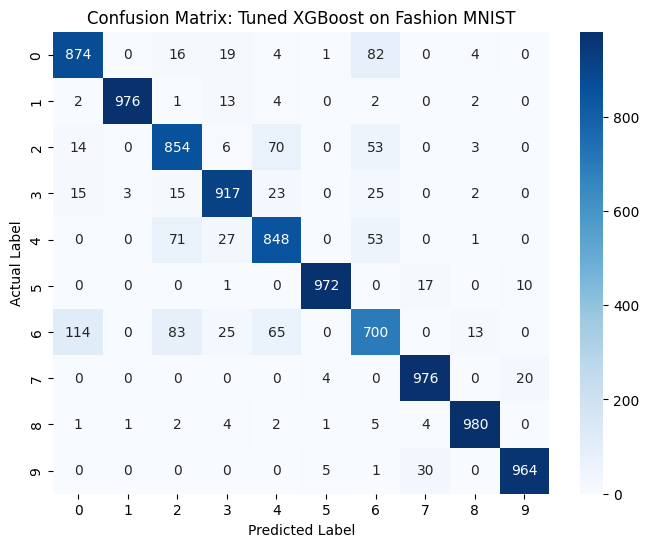


===== Classification Report =====

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.82      0.85      0.84      1000
           3       0.91      0.92      0.91      1000
           4       0.83      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.70      0.73      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
# ==================================================
# Evaluate the Final Model on Test Data
# ==================================================
test_preds = final_model.predict(X_test_np)

test_accuracy = accuracy_score(y_test_np, test_preds)
print(f"\n===== Final Test Accuracy (Tuned XGBoost): {test_accuracy:.4f} =====\n")

cm = confusion_matrix(y_test_np, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Tuned XGBoost on Fashion MNIST")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

print("\n===== Classification Report =====\n")
print(classification_report(y_test_np, test_preds))